In [11]:
from lib.models import *
from lib.datasets import Dataset2p0
from torch.utils.data import DataLoader
import torch
from torch import nn
from tqdm import tqdm
from lib.utils import cms,test_evaluation
import matplotlib.pyplot as plt
from torch.utils.data import TensorDataset,DataLoader
import plotly.express as px
import pandas as pd
from lib.utils import get_bout_statistics_for_predictions
import numpy as np
import seaborn as sns
device = 'cuda'
model = BigPapa().to(device)
model.load_state_dict(torch.load('25.pt',map_location='cuda'))

params = sum([p.flatten().size()[0] for p in list(model.parameters())])
print("Params: ",params)
data_dir = 'w9_centered'
trainloader = DataLoader(Dataset2p0(dir=f'{data_dir}/train/',labels=f'{data_dir}/y_train.pt'),batch_size=32,shuffle=True)
devloader = DataLoader(Dataset2p0(dir=f'{data_dir}/dev/',labels=f'{data_dir}/y_dev.pt'),batch_size=32,shuffle=True)
testloader = DataLoader(Dataset2p0(dir=f'{data_dir}/test/',labels=f'{data_dir}/y_test.pt'),batch_size=32,shuffle=True)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters())

Params:  8618


  0%|          | 0/3637 [00:00<?, ?it/s]/home/andrew/.local/lib/python3.10/site-packages/torch/nn/modules/conv.py:309: UserWarning: Using padding='same' with even kernel lengths and odd dilation may require a zero-padded copy of the input be created (Triggered internally at ../aten/src/ATen/native/Convolution.cpp:895.)
  return F.conv1d(input, weight, bias, self.stride,
100%|██████████| 3637/3637 [03:30<00:00, 17.24it/s]


(0.17808800312960077,
 tensor([1., 1., 2.,  ..., 1., 1., 2.]),
 tensor([1., 1., 2.,  ..., 1., 1., 2.]))

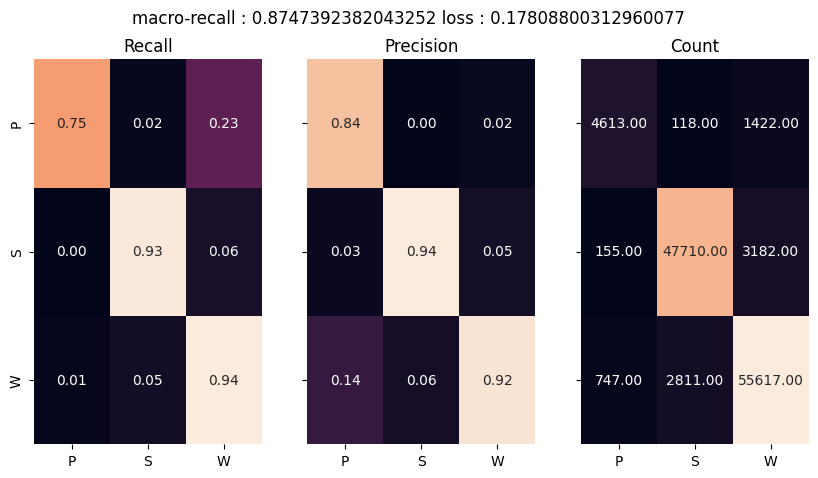

In [2]:
test_evaluation(trainloader,model,criterion)

  0%|          | 0/1819 [00:00<?, ?it/s]/home/andrew/.local/lib/python3.10/site-packages/torch/nn/modules/conv.py:309: UserWarning: Using padding='same' with even kernel lengths and odd dilation may require a zero-padded copy of the input be created (Triggered internally at ../aten/src/ATen/native/Convolution.cpp:895.)
  return F.conv1d(input, weight, bias, self.stride,
100%|██████████| 1819/1819 [01:45<00:00, 17.18it/s]


(0.18937351303036853,
 tensor([2., 2., 2.,  ..., 1., 1., 0.]),
 tensor([2., 2., 2.,  ..., 1., 2., 0.]))

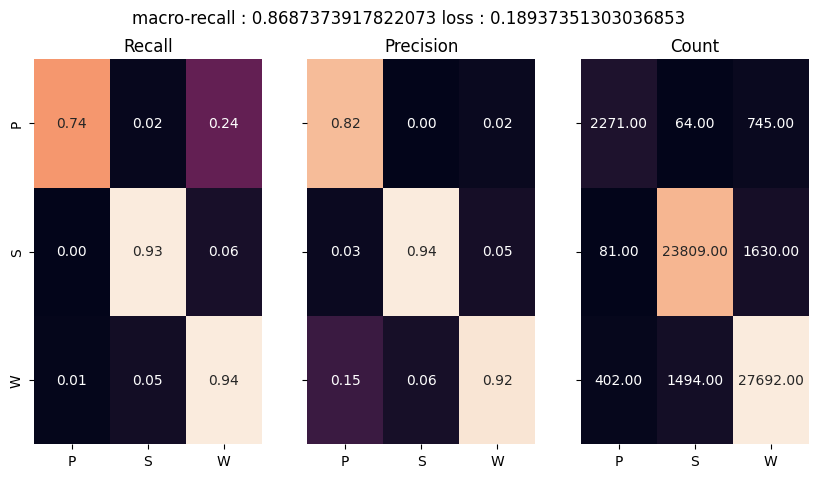

In [2]:
test_evaluation(devloader,model,criterion)

100%|██████████| 1819/1819 [01:44<00:00, 17.39it/s]


(0.18396057095737034,
 tensor([1., 1., 2.,  ..., 1., 1., 2.]),
 tensor([1., 1., 0.,  ..., 2., 1., 2.]))

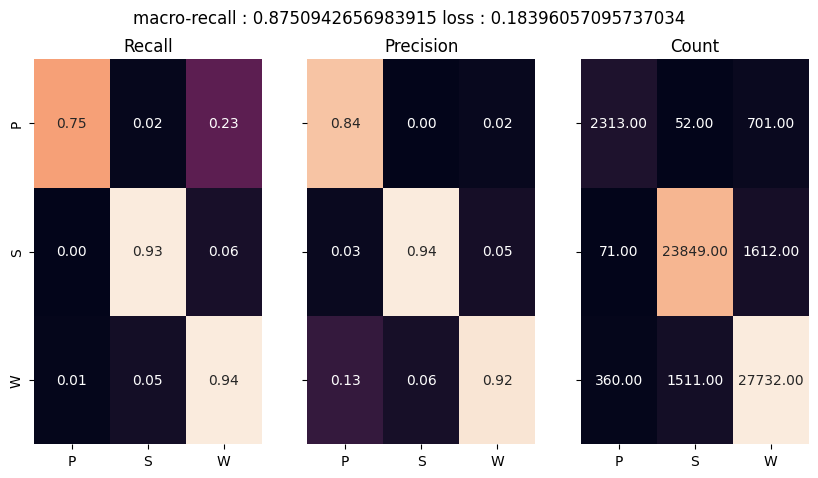

In [3]:
test_evaluation(testloader,model,criterion)

100%|██████████| 270/270 [00:10<00:00, 25.52it/s]


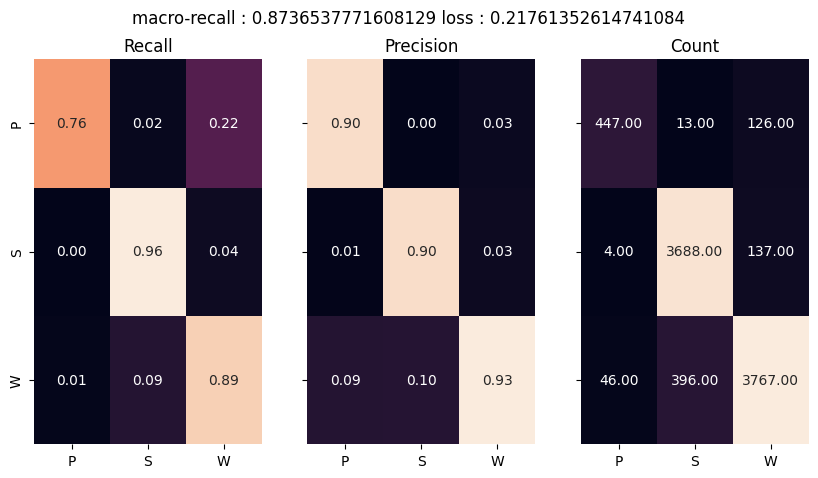

In [6]:
# evaluate single holdout
X,y = torch.load(f'{data_dir}/holdout_18.pt')
holdoutloader = DataLoader(TensorDataset(X,y),batch_size=32)
loss,y_true,y_pred = test_evaluation(holdoutloader,model,criterion)

pred_expert = np.array(y_pred).copy()

for j in range(len(pred_expert)-2):
    if(pred_expert[j+1] != pred_expert[j] and pred_expert[j+1] != pred_expert[j+2]):
        pred_expert[j+1] = pred_expert[j]
df = pd.DataFrame([y_true.numpy(),y_pred.detach().cpu().numpy(),pred_expert],index=['true','pred','expert']).T

df.loc[df['true'] == 2,'true'] = 'W'
df.loc[df['true'] == 1,'true'] = 'S'
df.loc[df['true'] == 0,'true'] = 'P'
df.loc[df['pred'] == 2,'pred'] = 'W'
df.loc[df['pred'] == 1,'pred'] = 'S'
df.loc[df['pred'] == 0,'pred'] = 'P'
df.loc[df['expert'] == 2,'expert'] = 'W'
df.loc[df['expert'] == 1,'expert'] = 'S'
df.loc[df['expert'] == 0,'expert'] = 'P'

# cms(y_true=y_true,y_pred=pred_expert)

In [12]:
fig = px.line(data_frame=df,y=['true','pred'])
fig.show(renderer='browser')

In [159]:
stats_pred = get_bout_statistics_for_predictions(df['pred'])
stats_pred

,P,S,W
total,21.333333,489.166667,928.166667
average,29.767442,109.925094,187.508418
counts,43.000000,267.000000,297.000000


In [160]:
stats_true = get_bout_statistics_for_predictions(df['true'])
stats_true

,P,S,W
total,48.500000,416.333333,973.833333
average,80.833333,117.830189,278.238095
counts,36.000000,212.000000,210.000000


In [158]:
(stats_true-stats_pred)/stats_true

,P,S,W
total,0.560137,-0.174940,0.046894
average,0.631743,0.067089,0.326086
counts,-0.194444,-0.259434,-0.414286


  0%|          | 0/270 [00:00<?, ?it/s]/home/andrew/.local/lib/python3.10/site-packages/torch/nn/modules/conv.py:309: UserWarning: Using padding='same' with even kernel lengths and odd dilation may require a zero-padded copy of the input be created (Triggered internally at ../aten/src/ATen/native/Convolution.cpp:895.)
  return F.conv1d(input, weight, bias, self.stride,
100%|██████████| 270/270 [00:10<00:00, 25.70it/s]


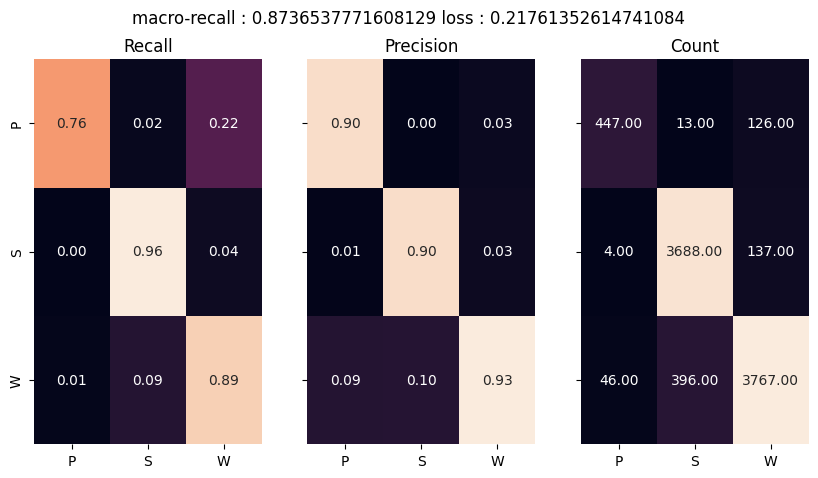

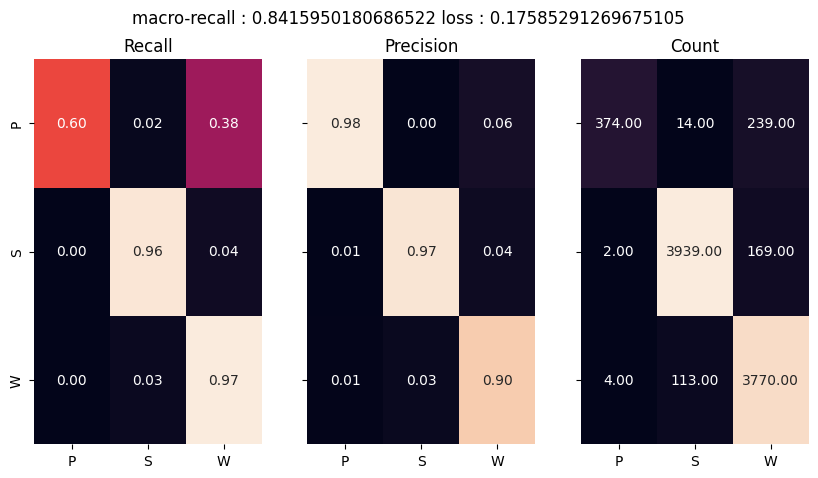

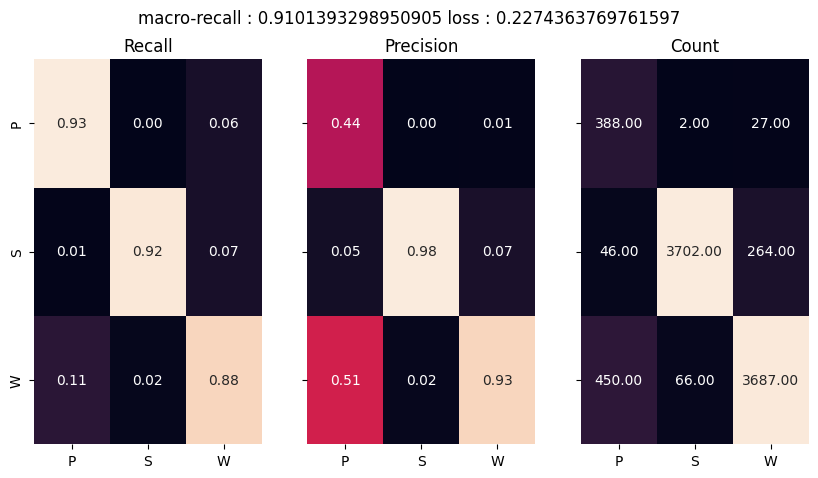

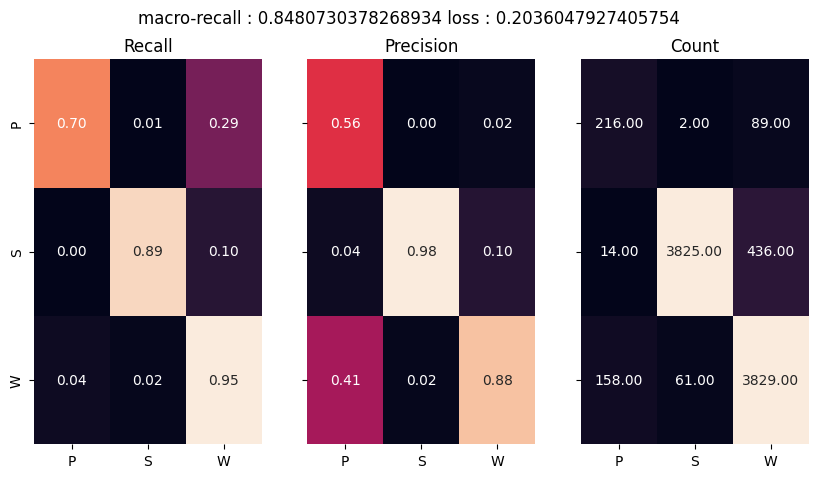

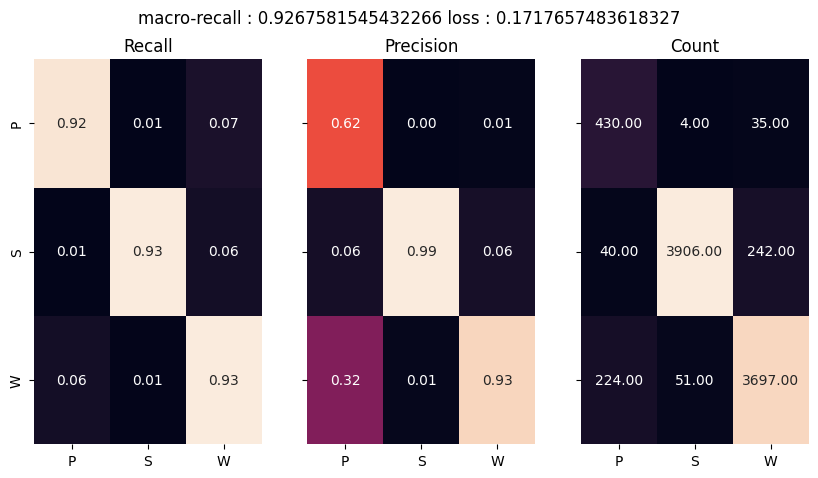

In [2]:
# evaluate single holdout
from sklearn.metrics import recall_score,precision_score,f1_score

holdout_idx = [18, 7, 13, 16, 12]
recalls = []
precisions = []
f1s = []
stats_true = pd.DataFrame()
stats_pred = pd.DataFrame()
for idx in holdout_idx:
    X,y = torch.load(f'{data_dir}/holdout_{idx}.pt')
    holdoutloader = DataLoader(TensorDataset(X,y),batch_size=32)
    loss,y_true,y_pred = test_evaluation(holdoutloader,model,criterion)

    pred_expert = np.array(y_pred).copy()

    for j in range(len(pred_expert)-2):
        if(pred_expert[j+1] != pred_expert[j] and pred_expert[j+1] != pred_expert[j+2]):
            pred_expert[j+1] = pred_expert[j]
    df = pd.DataFrame([y_true.numpy(),y_pred.detach().cpu().numpy(),pred_expert],index=['true','pred','expert']).T

    df.loc[df['true'] == 2,'true'] = 'W'
    df.loc[df['true'] == 1,'true'] = 'S'
    df.loc[df['true'] == 0,'true'] = 'P'
    df.loc[df['pred'] == 2,'pred'] = 'W'
    df.loc[df['pred'] == 1,'pred'] = 'S'
    df.loc[df['pred'] == 0,'pred'] = 'P'
    df.loc[df['expert'] == 2,'expert'] = 'W'
    df.loc[df['expert'] == 1,'expert'] = 'S'
    df.loc[df['expert'] == 0,'expert'] = 'P'
    stats_predi = get_bout_statistics_for_predictions(df['pred'])
    stats_truei = get_bout_statistics_for_predictions(df['true'])

    stats_pred = pd.concat([stats_pred,stats_predi.reset_index().melt(id_vars='index')])
    stats_true = pd.concat([stats_true,stats_truei.reset_index().melt(id_vars='index')])

    recall = recall_score(y_true=y_true,y_pred=y_pred,average='macro')
    precision = precision_score(y_true=y_true,y_pred=y_pred,average='macro')
    f1 = f1_score(y_true=y_true,y_pred=y_pred,average='macro')
    recalls.append(recall)
    precisions.append(precision)
    f1s.append(f1)

In [13]:
print(f1s)
print(torch.tensor(f1s).mean())
print(torch.tensor(f1s).std())
print(recalls)
print(torch.tensor(recalls).mean())
print(torch.tensor(recalls).std())
print(precisions)
print(torch.tensor(precisions).mean())
print(torch.tensor(precisions).std())

[0.8901747509100465, 0.8804187206949741, 0.8164158097175225, 0.8233959487364683, 0.8762144044417166]
tensor(0.8573, dtype=torch.float64)
tensor(0.0346, dtype=torch.float64)
[0.8736537771608129, 0.8415950180686522, 0.9101393298950905, 0.8480730378268934, 0.9267581545432266]
tensor(0.8800, dtype=torch.float64)
tensor(0.0375, dtype=torch.float64)
[0.9114355630294476, 0.9517738392006599, 0.7825748513375288, 0.8066395163630277, 0.8453360297842886]
tensor(0.8596, dtype=torch.float64)
tensor(0.0709, dtype=torch.float64)


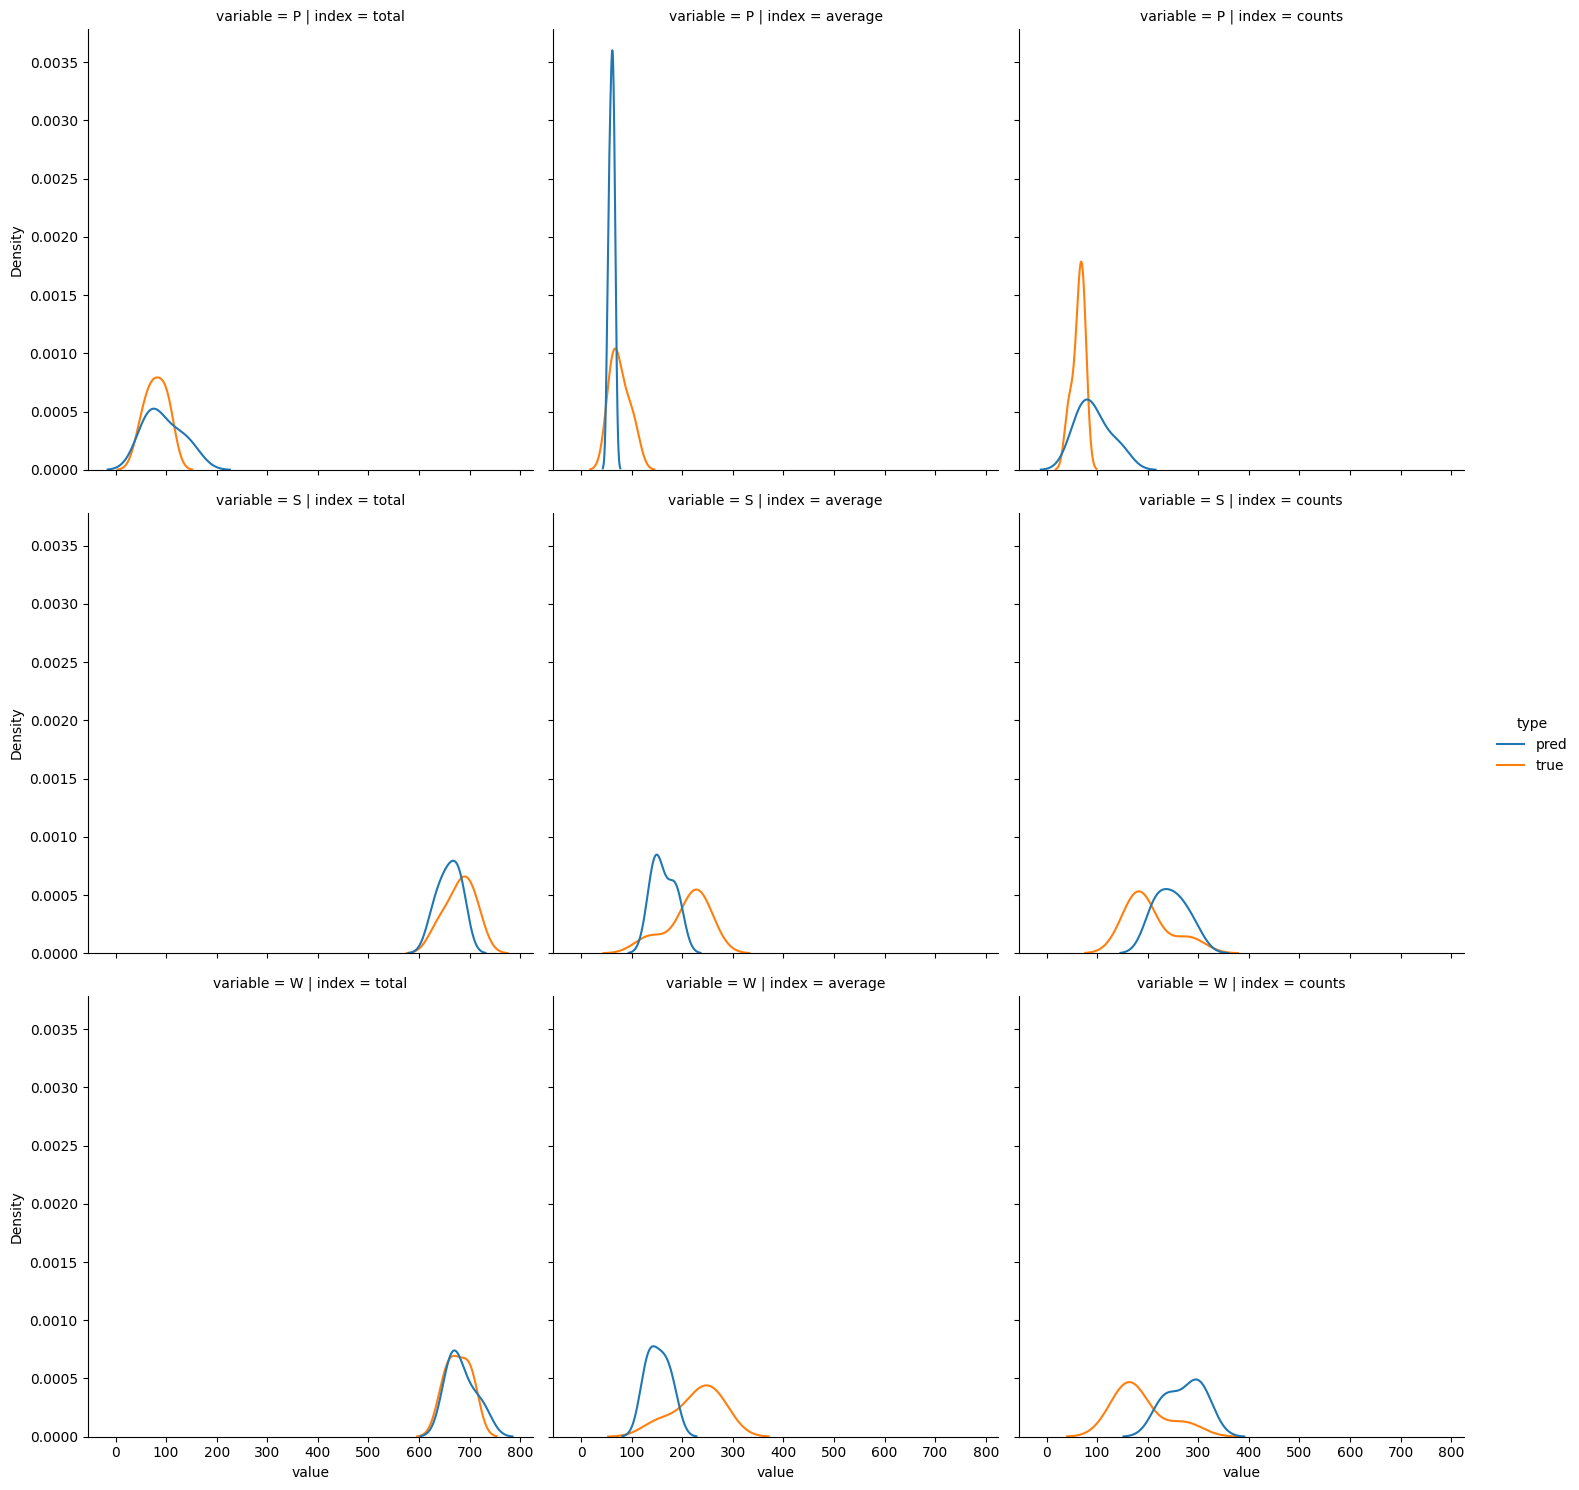

In [10]:
stats_pred['type'] = 'pred'
stats_true['type'] = 'true'

stats = pd.concat([stats_pred,stats_true])
sns.displot(data=stats.reset_index(drop=True),x='value',hue='type',col='index',row='variable',kind='kde')
plt.savefig('ot.jpg')

In [139]:
stats_true.loc[(stats_true['index'] == 'total'),'value'] = abs(stats_true[(stats_true['index'] == 'total')]['value']-stats_pred[(stats_pred['index'] == 'total')]['value'])/(stats_true[(stats_true['index'] == 'total')]['value'])

In [143]:
stats_true.loc[(stats_true['index'] == 'average'),'value'] = abs(stats_true[(stats_true['index'] == 'average')]['value']-stats_pred[(stats_pred['index'] == 'average')]['value'])/(stats_true[(stats_true['index'] == 'average')]['value'])

In [144]:
stats_true.loc[(stats_true['index'] == 'counts'),'value'] = abs(stats_true[(stats_true['index'] == 'counts')]['value']-stats_pred[(stats_pred['index'] == 'counts')]['value'])/(stats_true[(stats_true['index'] == 'counts')]['value'])

<AxesSubplot:xlabel='value', ylabel='Density'>

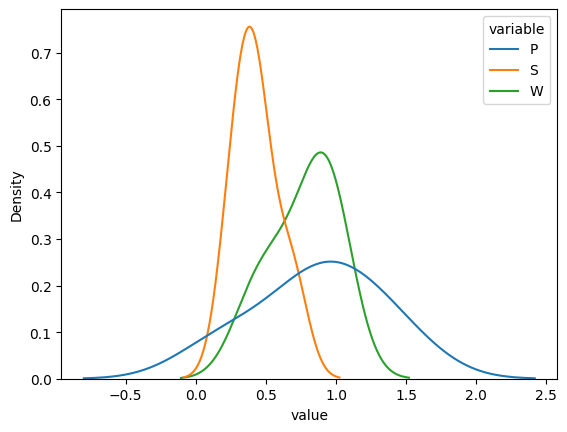

In [149]:
sns.kdeplot(data=stats_true.loc[(stats_true['index'] == 'counts')].reset_index(drop=True),x='value',hue='variable')